<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/GradCAM_CNN_Vs_ViT_Vs_Swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM_V1 (CNN)

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

total gradcam time: 7.16434907913208


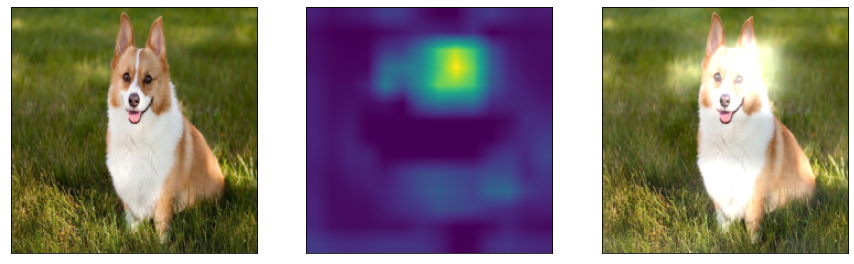

In [3]:
from urllib.request import urlretrieve
from PIL import Image
import os
import cv2
import time

def get_gradcam_multiclass(model, img):
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    # get the gradient of the output with respect to the parameters of the model
    logits[:, pred].backward(retain_graph=True)
    # pull the gradients out of the model
    gradients = model.get_activations_gradient()
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()
    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap
    
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))
img_url = 'https://www.animalfunfacts.net/images/stories/pets/dogs/pembroke_welsh_corgi_l.jpg'
urlretrieve(img_url, "img.jpg")
std = torch.tensor([0.229, 0.224, 0.225])
mean = torch.tensor([0.485, 0.456, 0.406])
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = Image.open("img.jpg")
img = transform(img)[None]

# initialize the VGG model
model = VGG()
# set the evaluation mode
model.eval()
st = time.time()
heatmap = get_gradcam_multiclass(model, img)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9
#plt.matshow(superimposed_img)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_V2 (CNN)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


total gradcam time: 3.2807154655456543


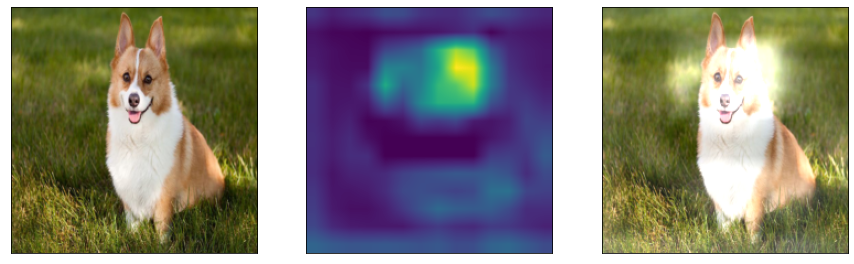

In [6]:
import torch 
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    # logits[:, pred].backward or logits.backward(pred_onehot[None] yields same result
    # pred_onehot = F.one_hot(pred, num_classes=1000)
    # logits.backward(pred_onehot[None], retain_graph=True)
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    # sum or mean produces similar outcomes
    #heatmap = torch.sum(activations, dim=1).squeeze().cpu()
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model = vgg19(pretrained=True)
model.eval();
last_conv_layer = model.features[34]
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9
#plt.matshow(superimposed_img)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_ViT_V1 (ViT)
Installation

In [1]:
!pip -q install timm

     |████████████████████████████████| 509 kB 6.1 MB/s 


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction: 263
prediction: 263


total gradcam time: 2.0581583976745605


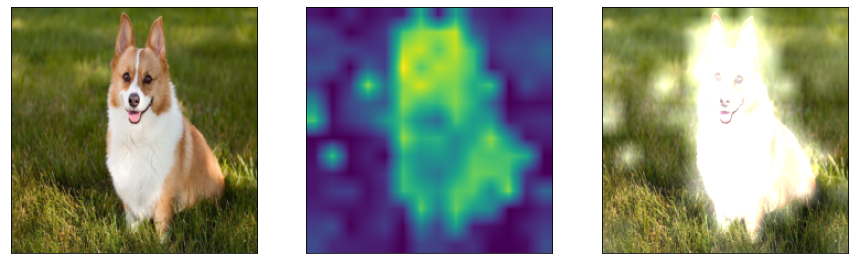

In [61]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

class ViT_Features(nn.Module):
    def __init__(self):
        super(ViT_Features, self).__init__()
        model_name = "vit_base_patch16_224"
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        self.vit = create_model(model_name, pretrained=True).to(device)

    def forward(self, x):
        patches = self.vit.patch_embed(x)
        pos_embed = self.vit.pos_embed
        transformer_input = torch.cat((self.vit.cls_token, patches), dim=1) + pos_embed #[1, 197, 768]
        x = transformer_input.clone() # critical part, it doesn't work w/o cloning
        for i, blk in enumerate(self.vit.blocks):
            x = blk(x)
        x = self.vit.norm(x)
        transformer_output =  x[:, 0]
        logits = self.vit.head(transformer_output)
        print('prediction:', int(torch.argmax(logits)))
        return logits

model = ViT_Features()
model.eval()
last_conv_layer = model.vit.blocks[11].norm1
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_ViT_V2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction: 263


total gradcam time: 2.165402412414551


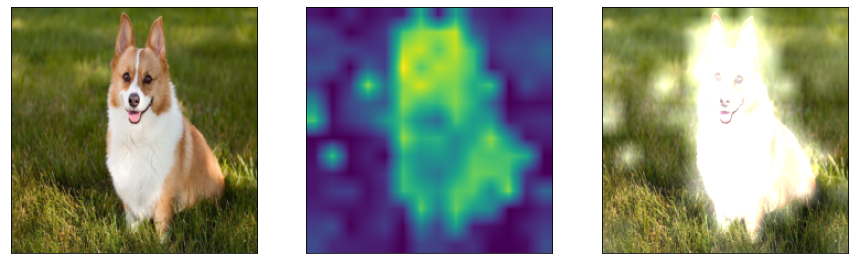

In [60]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model("vit_base_patch16_224", pretrained=True).to(device)
model.eval()
last_conv_layer = model.blocks[11].norm1
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9
#plt.matshow(superimposed_img)

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_HViT_V1
src: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer_hybrid.py

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


x: torch.Size([1, 50, 1024])
x: torch.Size([1, 1024])
prediction: 263


total gradcam time: 4.863991975784302


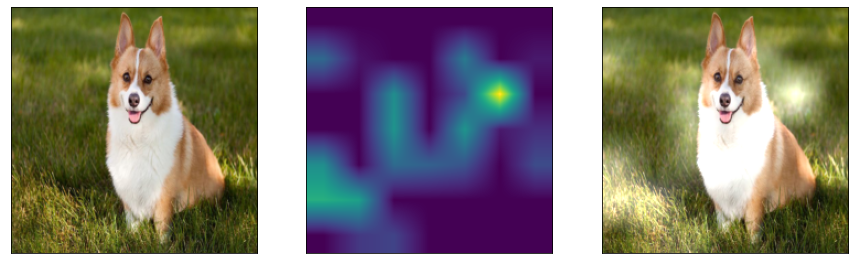

In [78]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model


class ViT_Features(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224"):
        super(ViT_Features, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        self.vit = create_model(model_name, pretrained=True).to(device)

    def forward(self, x):
        patches = self.vit.patch_embed(x)
        pos_embed = self.vit.pos_embed
        transformer_input = torch.cat((self.vit.cls_token, patches), dim=1) + pos_embed #[1, 197, 768]
        x = transformer_input.clone() # critical part, it doesn't work w/o cloning
        for i, blk in enumerate(self.vit.blocks):
            x = blk(x)
        x = self.vit.norm(x)
        print('x:', x.shape)
        transformer_output =  x[:, 0]
        print('x:', transformer_output.shape)
        logits = self.vit.head(transformer_output)
        return logits

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

#vit_base_r50_s16_224 (No pretrained)
#vit_base_r50_s16_224_in21k 
#vit_large_r50_s32_224  (have pretrain)
model = ViT_Features(model_name='vit_large_r50_s32_224')
model.eval()
last_conv_layer = model.vit.blocks[11].norm1
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_SWIN_Transformer_V1
src:https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer_v2_cr.py

https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer_v2.py

prediction: 263


total gradcam time: 1.7237143516540527


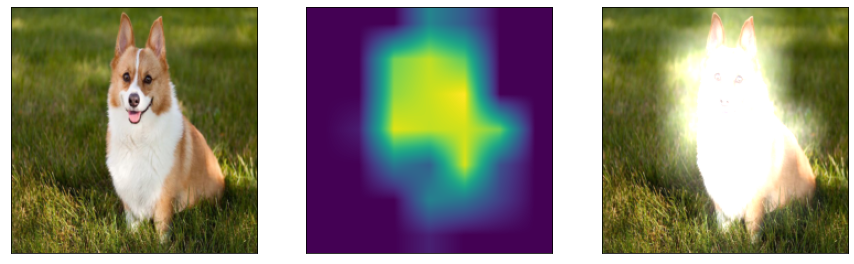

In [93]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

class SwinTranformer_Features(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224"):
        super(SwinTranformer_Features, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # create a SwinT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer_v2_cr.py
        self.swintran = create_model(model_name, pretrained=True).to(device)

    def forward(self, x):
        x = self.swintran.patch_embed(x)
        for i, stage in enumerate(self.swintran.stages):
            x = stage(x)
        
        logits = self.swintran.head(x[:, :, 0, 0])
        return logits

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, :, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

# swinv2_base_window8_256, swinv2_cr_small_224
model = SwinTranformer_Features(model_name='swinv2_cr_small_224')
model.eval()
last_conv_layer = model.swintran.stages[3].blocks[1].norm2
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)


# GradCAM_SWIN_Transformer_V2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction: 263


total gradcam time: 1.5935032367706299


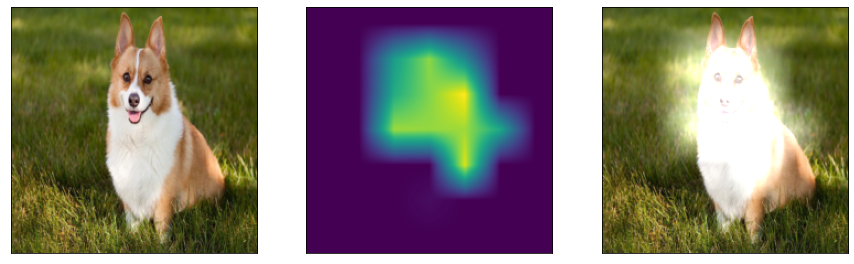

In [57]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, :, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

#swinv2_cr_small_224 #yes pretrained
#swinv2_cr_base_224 #No pretrained
# swinv2_base_window8_256 #yes pretrained
model = create_model("swinv2_cr_small_224", pretrained=True).to(device)
model.eval()

last_conv_layer = model.stages[3].blocks[1].norm2
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_SWIN_Transformer_V2 (256x256)
src: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer_v2.py

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction: 263


total gradcam time: 3.2361807823181152


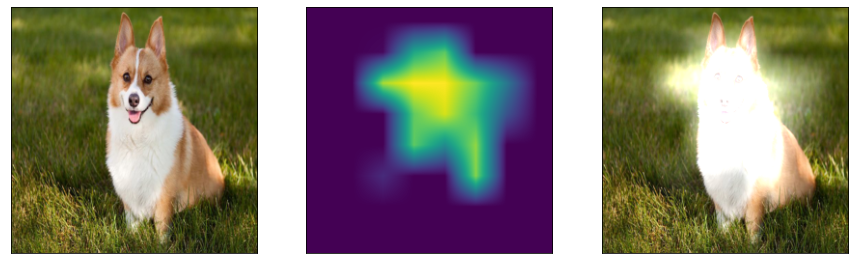

In [99]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, :, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


transform = transforms.Compose([transforms.Resize((256, 256)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = Image.open("img.jpg")
img = transform(img)[None]

# swinv2_base_window8_256 #yes pretrained
model = create_model("swinv2_base_window8_256", pretrained=True).to(device)
model.eval()

last_conv_layer = model.layers[3].blocks[1].norm2
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# GradCAM_SWIN_Transformer_V1 (256x256)


prediction: 263


total gradcam time: 3.0341036319732666


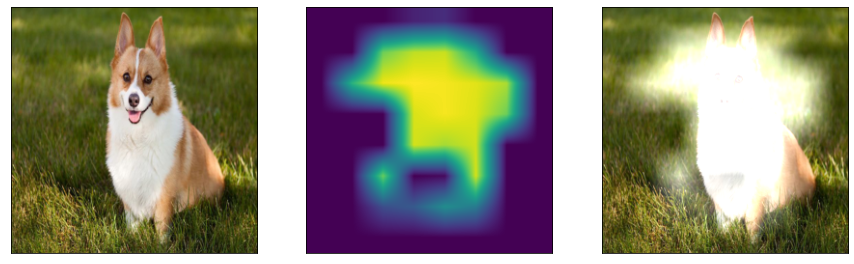

In [106]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

class SwinTranformer_Features(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224"):
        super(SwinTranformer_Features, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # create a SwinT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer_v2_cr.py
        self.swintran = create_model(model_name, pretrained=True).to(device)

    def forward(self, x):
        x = self.swintran.patch_embed(x)
        for i, layer in enumerate(self.swintran.layers):
            x = layer(x)
        
        x = self.swintran.norm(x)
        logits = self.swintran.head(x[:, 0, :])
        return logits
        
def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, :, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


transform = transforms.Compose([transforms.Resize((256, 256)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = Image.open("img.jpg")
img = transform(img)[None]

# swinv2_base_window8_256 #yes pretrained
model = SwinTranformer_Features(model_name='swinv2_base_window8_256')
model.eval()

last_conv_layer = model.swintran.layers[3].blocks[1].norm2
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction: 263


total gradcam time: 2.267179012298584


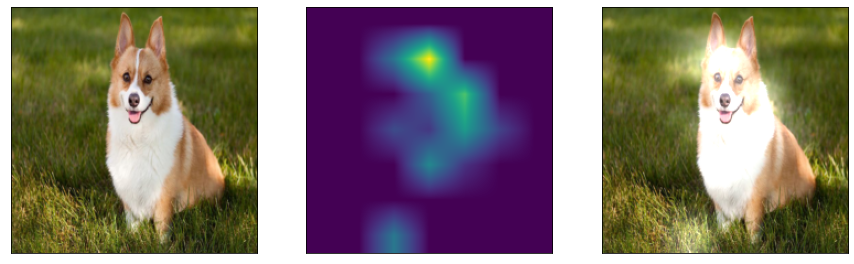

In [120]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

# x = transformer_input.clone() # critical part, it doesn't work w/o cloning
#         for i, blk in enumerate(self.vit.blocks):
#             x = blk(x)
#         x = self.vit.norm(x)
#         transformer_output =  x[:, 0]


class SwinTranformer_Features(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224"):
        super(SwinTranformer_Features, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # create a SwinT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer_v2_cr.py
        self.swintran = create_model(model_name, pretrained=True).to(device)

    def forward(self, x):
        x = self.swintran.patch_embed(x)

        for i, layer in enumerate(self.swintran.layers):
            x = layer(x)

        x = self.swintran.norm(x)
        x = x.mean(dim=1)
        logits = self.swintran.head(x)
        return logits
        
def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, :, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = Image.open("img.jpg")
img = transform(img)[None]

# swin_base_patch4_window7_224 #yes pretrained
model = SwinTranformer_Features(model_name='swin_base_patch4_window7_224')
model.eval()

last_conv_layer = model.swintran.layers[3].blocks[1].norm2
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
heatmap = heatmap.numpy()
img_rev = img * std[:,None, None] + mean[:,None, None]
img_rev = img_rev.squeeze().permute(1,2,0)
heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_rev))
ax[1].imshow(heatmap)
ax[2].imshow(superimposed_img)

# ViTs from https://github.com/jeonsworld/ViT-pytorch

In [4]:
!pip -q install ml_collections
! git clone https://github.com/jeonsworld/ViT-pytorch
%cd ViT-pytorch
! wget https://storage.googleapis.com/vit_models/imagenet21k%2Bimagenet2012/R50%2BViT-B_16.npz
! touch models/__init__.py

Cloning into 'ViT-pytorch'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 21.20 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/ViT-pytorch
--2022-08-23 11:43:03--  https://storage.googleapis.com/vit_models/imagenet21k%2Bimagenet2012/R50%2BViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395916008 (378M) [application/octet-stream]
Saving to: ‘R50+ViT-B_16.npz’

R50+ViT-B_16.npz    100%[===================>] 377.57M   215MB/s    in 1.8s    

2022-08-23 11:43:05 (215 MB/s) - ‘R50+ViT-B_16.npz’ saved [395916008/395916008]



load_pretrained: grid-size from 24 to 14
prediction: 263


total gradcam time: 2.9075047969818115


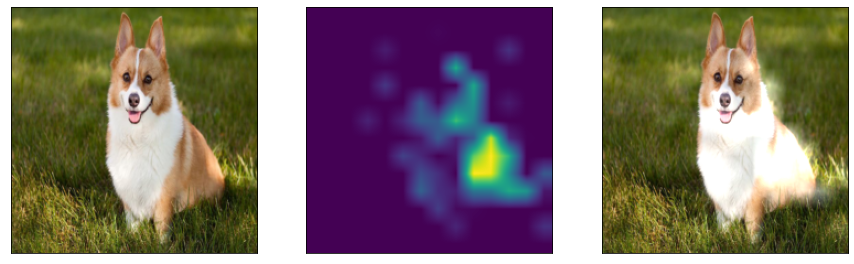

load_pretrained: grid-size from 24 to 14
prediction: 263


total gradcam time: 2.9066731929779053


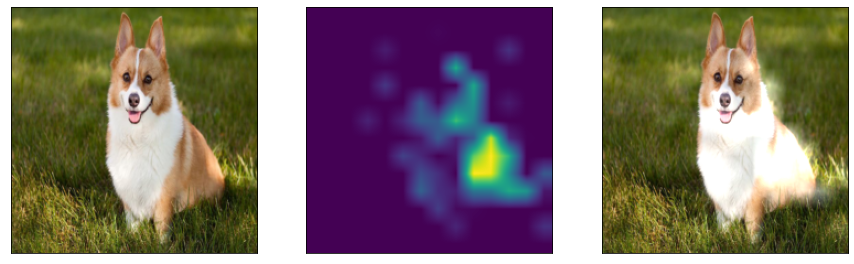

In [48]:
from models.modeling import VisionTransformer, CONFIGS
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import cv2


class HViT_Features_V1(nn.Module):
    def __init__(self, model_name="R50-ViT-B_16"):
        super(HViT_Features_V1, self).__init__()
        config = CONFIGS[model_name]
        self.hvit = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
        self.hvit.load_from(np.load("R50+ViT-B_16.npz"))

    def forward(self, x):
        x = self.hvit.transformer.embeddings(x)
        x, att_mat = self.hvit.transformer.encoder(x)
        logits = self.hvit.head(x[:, 0])
        return logits

class HViT_Features_V2(nn.Module):
    def __init__(self, model_name="R50-ViT-B_16"):
        super(HViT_Features_V2, self).__init__()
        config = CONFIGS[model_name]
        self.hvit = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
        self.hvit.load_from(np.load("R50+ViT-B_16.npz"))

    def forward(self, x):
        x = self.hvit.transformer.embeddings(x)
        for i, blk in enumerate(self.hvit.transformer.encoder.layer):
            x, _ = blk(x)

        x = self.hvit.transformer.encoder.encoder_norm(x)
        logits = self.hvit.head(x[:, 0])
        return logits

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor):
    hw = int((tensor.shape[1]) ** (1/2))
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      hw, hw, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print('prediction:', int(torch.argmax(logits)))
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

def gradcam_plot(heatmap, img, mean, std):
    heatmap = heatmap.numpy()
    img_rev = img * std[:,None, None] + mean[:,None, None]
    img_rev = img_rev.squeeze().permute(1,2,0)
    heatmap = cv2.resize(heatmap, (img_rev.shape[1], img_rev.shape[0]))
    superimposed_img = np.array(img_rev) + heatmap[:,:,None] * 0.9

    num_img = 3
    fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
    ax[0].imshow(np.array(img_rev))
    ax[1].imshow(heatmap)
    ax[2].imshow(superimposed_img)
    plt.show()

mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = Image.open("../img.jpg")
img = transform(img)[None]

model = HViT_Features_V1(model_name='R50-ViT-B_16')
model.eval()

last_conv_layer = model.hvit.transformer.encoder.layer[11].attention_norm
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
gradcam_plot(heatmap, img, mean, std)


model = HViT_Features_V2(model_name='R50-ViT-B_16')
model.eval()

last_conv_layer = model.hvit.transformer.encoder.layer[11].attention_norm
st = time.time()
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)
et = time.time()
print('total gradcam time:',et-st)
gradcam_plot(heatmap, img, mean, std)